# Modeling and Simulation in Python

Chapter 10

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### SIR implementation

We'll use a `State` object to represent the number (or fraction) of people in each compartment.

In [2]:
init = State(S=89, I=1, R=0)

,values
S,89
I,1
R,0


To convert from number of people to fractions, we divide through by the total.

In [3]:
init /= sum(init)

,values
S,0.988889
I,0.011111
R,0.000000


`make_system` creates a `System` object with the given parameters.

In [4]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

Here's an example with hypothetical values for `beta` and `gamma`.

In [5]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)

,values
init,S 0.988889 I 0.011111 R 0.000000 dtyp...
t0,0
t_end,98
beta,0.333333
gamma,0.25


The update function takes the state during the current time step and returns the state during the next time step.

In [6]:
def update_func(state, t, system):
    """Update the SIR model.
    
    state: State with variables S, I, R
    t: time step
    system: System with beta and gamma
    
    returns: State object
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

To run a single time step, we call it like this:

In [7]:
state = update_func(init, 0, system)

,values
S,0.985226
I,0.011996
R,0.002778


Now we can run a simulation by calling the update function for each time step.

In [8]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    system: System object
    update_func: function that updates state
    
    returns: State object for final state
    """
    state = system.init
    
    for t in linrange(system.t0, system.t_end-1):
        state = update_func(state, t, system)
        
    return state

The result is the state of the system at `t_end`

In [9]:
run_simulation(system, update_func)

,values
S,0.520568
I,0.000666
R,0.478766


**Exercise**  Suppose the time between contacts is 4 days and the recovery time is 5 days.  After 14 weeks, how many students, total, have been infected?

Hint: what is the change in `S` between the beginning and the end of the simulation?

In [10]:
# Solution

tc = 4      # time between contacts in days 
tr = 5      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)
s0 = system.init.S

final = run_simulation(system, update_func)
s_end = final.S
s0 - s_end

0.3787177442414792

### Using TimeSeries objects

If we want to store the state of the system at each time step, we can use one `TimeSeries` object for each state variable.

In [11]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add three Series objects to the System: S, I, R
    
    system: System object
    update_func: function that updates state
    """
    S = TimeSeries()
    I = TimeSeries()
    R = TimeSeries()

    state = system.init
    t0 = system.t0
    S[t0], I[t0], R[t0] = state
    
    for t in linrange(system.t0, system.t_end-1):
        state = update_func(state, t, system)
        S[t+1], I[t+1], R[t+1] = state
    
    return S, I, R

Here's how we call it.

In [12]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)
S, I, R = run_simulation(system, update_func)

And then we can plot the results.

In [13]:
def plot_results(S, I, R):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', color='blue', label='Susceptible')
    plot(I, '-', color='red', label='Infected')
    plot(R, ':', color='green', label='Recovered')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

Here's what they look like.

Saving figure to file figs/chap05-fig01.pdf


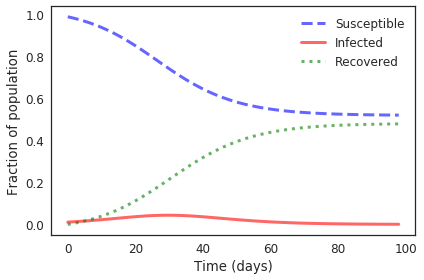

In [14]:
plot_results(S, I, R)
savefig('figs/chap05-fig01.pdf')

### Using a DataFrame

Instead of making three `TimeSeries` objects, we can use one `DataFrame`.

We have to use `row` to selects rows, rather than columns.  But then Pandas does the right thing, matching up the state variables with the columns of the `DataFrame`.

In [15]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.row[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end-1):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    
    return frame

Here's how we run it, and what the result looks like.

In [16]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)
results = run_simulation(system, update_func)
results.head()

,S,I,R
0,0.988889,0.011111,0.000000
1,0.985226,0.011996,0.002778
2,0.981287,0.012936,0.005777
3,0.977055,0.013934,0.009011
4,0.972517,0.014988,0.012494


We can extract the results and plot them.

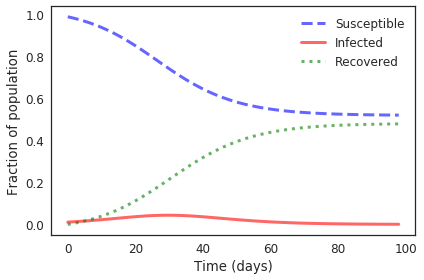

In [17]:
plot_results(results.S, results.I, results.R)

**Exercise**  Suppose the time between contacts is 4 days and the recovery time is 5 days.  Simulate this scenario for 14 days and plot the results.

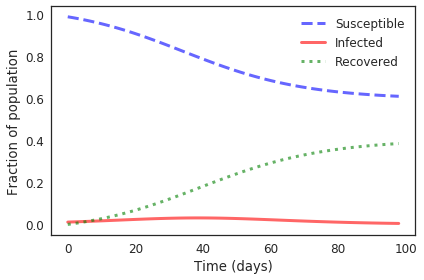

In [18]:
# Solution

tc = 4      # time between contacts in days 
tr = 5      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)
results = run_simulation(system, update_func)

plot_results(results.S, results.I, results.R)

### Metrics

Given the results, we can compute metrics that quantify whatever we are interested in, like the total number of sick students, for example.

In [19]:
def calc_total_infected(results, system):
    """Fraction of population infected during the simulation.
    
    results: DataFrame with columns S, I, R
    system: System object
    
    returns: fraction of population
    """
    return results.S[system.t0] - results.S[system.t_end]

Here's an example.|

In [20]:
system.beta = 0.333
system.gamma = 0.25
results = run_simulation(system, update_func)
print(system.beta, system.gamma, calc_total_infected(results, system))

0.333 0.25 0.46716293183605073


**Exercise:** Write functions that take a `DataFrame` and a`System` object as parameters and compute the other metrics mentioned in the book:

1.  The fraction of students who are sick at the peak of the outbreak.

2.  The day the outbreak peaks.

3.  The fraction of students who are sick at the end of the semester.

Note: Not all of these functions require the `System` object, but when you write a set of related functons, it is often convenient if they all take the same parameters.

Hint:  If you have a `TimeSeries` called `I`, you can compute the largest value of the series like this:

    I.max()

And the index of the largest value like this:

    I.idxmax()

You can read about these functions in the `Series` [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html).

In [21]:
# Solution

def fraction_sick_at_peak(results, system):
    return results.I.max()

In [22]:
# Solution

fraction_sick_at_peak(results, system)

0.043536202687592354

In [23]:
# Solution

def time_of_peak(results, system):
    return results.I.idxmax()

In [24]:
# Solution

time_of_peak(results, system)

30

In [25]:
# Solution

def sick_at_end(results, system):
    return results.I[system.t_end]

In [26]:
# Solution

sick_at_end(results, system)

0.0006741943156034474

### What if?

We can use this model to evaluate "what if" scenarios.  For example, this function models the effect of immunization by moving some fraction of the population from S to R before the simulation starts.

In [27]:
def add_immunization(system, fraction):
    """Immunize a fraction of the population.
    
    Moves the given fraction from S to R.
    
    system: System object
    fraction: number from 0 to 1
    """
    system.init.S -= fraction
    system.init.R += fraction

Let's start again with the system we used in the previous sections.

In [28]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)

,values
init,S 0.988889 I 0.011111 R 0.000000 dtyp...
t0,0
t_end,98
beta,0.333333
gamma,0.25


And run the model without immunization.

In [29]:
results = run_simulation(system, update_func)
calc_total_infected(results, system)

0.468320811028781

Now with 10% immunization.

In [30]:
system2 = make_system(beta, gamma)
add_immunization(system2, 0.1)
results2 = run_simulation(system2, update_func)
calc_total_infected(results2, system2)

0.30650802853979753

10% immunization leads to a drop in infections of 16 percentage points.

Here's what the time series looks like for S, with and without immunization.

Saving figure to file figs/chap05-fig02.pdf


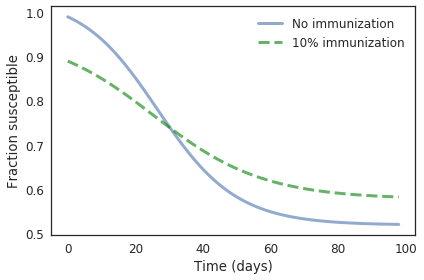

In [31]:
plot(results.S, '-', label='No immunization')
plot(results2.S, 'g--', label='10% immunization')

decorate(xlabel='Time (days)',
         ylabel='Fraction susceptible')

savefig('figs/chap05-fig02.pdf')

Now we can sweep through a range of values for the fraction of the population who are immunized.

In [32]:
immunize_array = linspace(0, 1, 11)
for fraction in immunize_array:
    system = make_system(beta, gamma)
    add_immunization(system, fraction)
    results = run_simulation(system, update_func)
    print(fraction, calc_total_infected(results, system))

0.0 0.468320811028781
0.1 0.30650802853979753
0.2 0.16136545700638427
0.30000000000000004 0.0728155898425179
0.4 0.03552021675299155
0.5 0.019688715782459176
0.6000000000000001 0.011622057998337987
0.7000000000000001 0.006838737800619332
0.8 0.003696496253713877
0.9 0.0014815326722661948
1.0 -0.00016121210941239666


This function does the same thing and stores the results in a `Sweep` object.

In [33]:
def sweep_immunity(immunize_array):
    """Sweeps a range of values for immunity.
    
    immunize_array: array of fraction immunized
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    
    for fraction in immunize_array:
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        results = run_simulation(system, update_func)
        sweep[fraction] = calc_total_infected(results, system)
        
    return sweep

Here's how we run it.

In [34]:
immunize_array = linspace(0, 1, 21)
infected_sweep = sweep_immunity(immunize_array)

,values
0.00,0.468321
0.05,0.387288
0.10,0.306508
0.15,0.229234
0.20,0.161365
0.25,0.108791
0.30,0.072816
0.35,0.049938
0.40,0.035520
0.45,0.026121


And here's what the results look like.

Saving figure to file figs/chap05-fig03.pdf


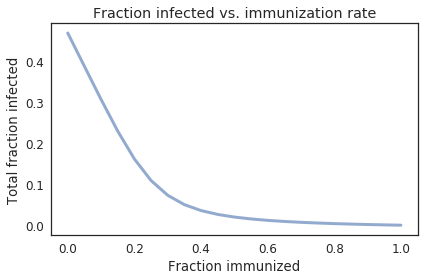

In [35]:
plot(infected_sweep)

decorate(xlabel='Fraction immunized',
         ylabel='Total fraction infected',
         title='Fraction infected vs. immunization rate',
         legend=False)

savefig('figs/chap05-fig03.pdf')

If 40% of the population is immunized, less than 4% of the population gets sick.

**Exercise:** 